This is a [jupyter](http://jupyter.org) notebook.

Open the notebook by (1) copying this file into a directory, (2) launching jupyter notebook in that directory
and (3) selecting the notebook.

# <u><font color= 'blue'>Music Synthesis</font> </u>
### <i>Practical Assignment 2, EE210 (Spring 2017) </i>
___
A notebook by ___Shashwat Shukla___ and ___Dhruv Ilesh Shah___ 
___
__Required Packages:__ Python(2.7+), NumPy, math, cmath, SciPy.io _(Optional, to simplify IO operations)_
___
In this notebook, we describe our method for synthesising music, given the sequences of notes and their timings. We have added higher harmonics to each tone being played. We also modulated the temporal envelope of the notes played. 
The temporal envelope has been modelled using the ADSR. 

Our code is very modular and all parameters of the ADSR model and for the harmonic content are fully configurable. We have fixed the values of our parameters to model the timbre of an acoustic guitar. We have also implemented a simple model for a piano.  

We first define the parameters of our model. All of these can be tweaked as we wish. 

In [19]:
%matplotlib inline
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
from cmath import *
#import sounddevice as sd

# Specify parameters for the model
harmonics = np.array([1., - 1. / 9, 1. / 25])  # Spectral Profile
adsr = np.array([80, 750, 0, 0])  # Temporal Profile (ms)
rate = 16  # sampling rate in kHz
total = np.sum(adsr)  # total time for which one pluck persists

## <u><font color="blue"> Modelling the Guitar </font></u>

## The Harmonic Spectrum

Each musical instrument has it's own harmonic spectrum. This spectrum arises by the superposition of higher harmonics on the vibrations of the fundamental, due to the physical characteristics of the instrument, which vary greatly from instrument to instrument. 

The following function generates the resulting waveform of the superposition of all harmonics. Note that only the third and fifth harmonics have been included, as they are found to have the greatest magnitude for most instruments. 

![The Problem](Pics/GuitarHarmonics.png)

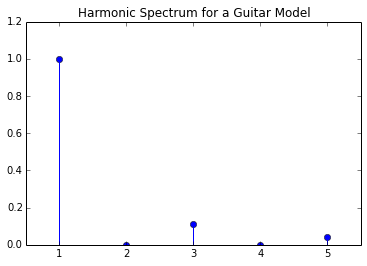

In [24]:
harmonic_spectrum_guitar = [[0, 1, 2, 3, 4, 5], [0, 1, 0, 1./9, 0, 1./25]]

plt.stem(harmonic_spectrum_guitar[0], harmonic_spectrum_guitar[1])
plt.axis([0.5, 5.5, 0, 1.2])
plt.title("Harmonic Spectrum for a Guitar Model")

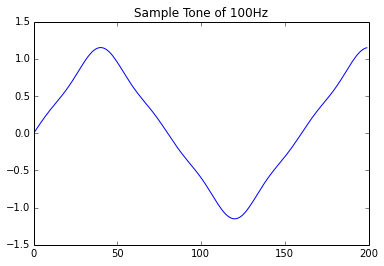

In [14]:
def gen_tone(f):
	t = np.arange(total * rate)
	x = np.sin(2 * np.pi * f * t / (1000 * rate))
	x = x + harmonics[1] * np.sin(2 * np.pi * 3 * f * t / (1000 * rate))
	x = x + harmonics[2] * np.sin(2 * np.pi * 5 * f * t / (1000 * rate))
	return x

#Plot the resulting waveform containing the harmonics
tone = gen_tone(100)
plt.plot(tone[:200])
plt.title("Sample Tone of 100Hz")

## The Temporal ADSR Envelope

The amplitude of sound generated by any instrument reaches a peak and then dies off after some time if the note is not being held. Thus there is temporal variation in the amplitude envelope of the sound generated by any instrument.
The ADSR is a simple, linear model for this time-variation. Despite it's apparent simplicity, it is very general and can be tuned to mimic profiles of many real instruments. 
ADSR stands for Attack, Delay, Sustain and Release. 

Stringed instruments like the guitar and ukelele don't allow for a sustain (and hence a release). The amplitude profile for such instruments is hence easily modelled by a short attack time followed by a proportionately larger delay time. 

Instruments like pipe-organs and keyboards allow a note to be held down for as long as the player wishes. This is modelled by a sustain time followed by the corresponding release. 

The following is code to generate the ADSR time-profile given the time durations for attack and delay. Sustain and release are to be implemented subsequently.
The resultant envelope is then plotted. 

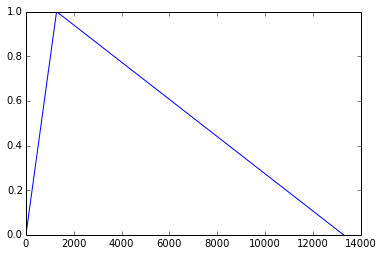

In [8]:
def gen_impulse():
	global adsr, rate;
	if (adsr[2]!=0 or adsr[3]!= 0):
		print "Please Remove S, R values. Working on that!"
		return
	impulse = np.zeros(total * rate)
	for i in range(total * rate):
		if(i < adsr[0] * rate):
			impulse[i] = (1.0 * i / rate) / adsr[0]
		elif(i < (adsr[0] + adsr[1]) * rate):
			impulse[i] = 1.0 * (adsr[0] + adsr[1] - 1.0 * i / rate) / adsr[1]
		# Add code for sustain and release also
	return impulse

impulse = gen_impulse()
plt.plot(impulse)

The waveform of the sound that any instrument emits as a result of a note being played, is then simply the multiplication of the temporal waveform with the harmonically enriched sinusoid waveform. 
Thus the timbre of our sound is characterised by both these waveforms.

The net output has been plotted below for this example.

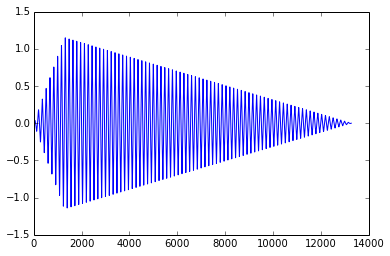

In [18]:
out = np.multiply(impulse, tone)
plt.plot(out[:30000])

It is intereting to see that since a guitar has a fixed drop time, the decay is not really dependent on the duration between the nodes. Hence, we would need to account for the overlap of notes when preparing the code. This has been shown later.

## <u><font color="blue"> Modelling the Piano </font></u>

## The Harmonic Spectrum

The Piano is an instrument which has synthesised sound, and hence it's harmonic spectrum can be designed as required. Here, we have used an envelope that dies with $ \frac{1}{f_n} $.

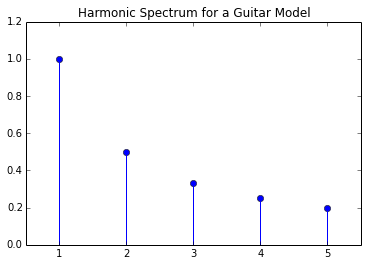

In [23]:
harmonic_spectrum_piano = [[0, 1, 2, 3, 4, 5], [0, 1, 1./2, 1./3, 1./4, 1./5]]

plt.stem(harmonic_spectrum_piano[0], harmonic_spectrum_piano[1])
plt.axis([0.5, 5.5, 0, 1.2])
plt.title("Harmonic Spectrum for a Guitar Model")

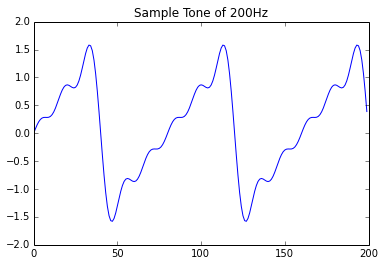

In [44]:
harmonics = np.array([1., - 1./2,  1. / 3, - 1./4, 1. / 5])  # Spectral Profile

def gen_tone(f, duration):
	global rate, harmonics
	t = np.arange(duration * rate)
	x = np.sin(2 * np.pi * f * t / (1000 * rate))
	x = x + harmonics[1] * np.sin(2 * np.pi * 2 * f * t / (1000 * rate))
	x = x + harmonics[2] * np.sin(2 * np.pi * 3 * f * t / (1000 * rate))
	x = x + harmonics[3] * np.sin(2 * np.pi * 4 * f * t / (1000 * rate))
	x = x + harmonics[4] * np.sin(2 * np.pi * 5 * f * t / (1000 * rate))
	return x


#Plot the resulting waveform containing the harmonics
tone = gen_tone(200, 200)
plt.plot(tone[:200])
plt.title("Sample Tone of 200Hz")

## The Temporal ADSR Envelope

Unlike a guitar, the piano has it's main period in the _sustain_ period. Typically, it also involves an adaptive period, with the player holding the note for the required period. We can model this, by a brief attack period followed by a large sustain period, and a short release period.

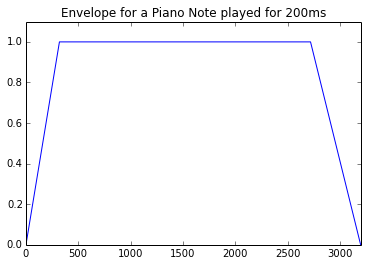

In [43]:
ADSR = [0.1, 0, 0.75, 0.15]

def get_envelope(duration):
	global rate
	envelope = np.arange(duration * rate * (ADSR[0]))
	envelope = envelope / np.max(envelope)
	envelope = np.append(envelope, np.ones(ADSR[2] * duration * rate))
	x = np.arange(duration * rate * ADSR[3])
	x = x / np.max(x)
	release = 1 - x
	# envelope = list(envelope)
	envelope = np.append(envelope, release)
	return envelope

env = get_envelope(200)
plt.axis([0, 3200, 0, 1.1])
plt.title("Envelope for a Piano Note played for 200ms")
plt.plot(env)

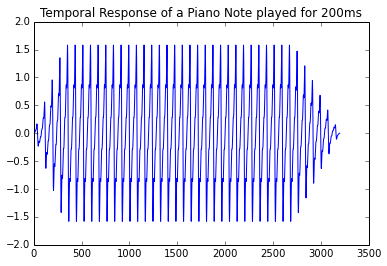

In [42]:
tune = tone * env
plt.title("Temporal Response of a Piano Note played for 200ms")
plt.plot(tune)

## <u><font color="blue"> Putting It Together </font></u>

Now that we have the necessary components for generating a tone sequence, let's see how it can be done.  
_(We need some helper functions for file handling. These have been given below, or in file helper.py)_

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import sounddevice as sd
import csv
import re


def get_notes(songfile):
	song = []
	with open(songfile, 'rb') as csvfile:
		songreader = csv.reader(csvfile, delimiter = ' ')
		for row in songreader:
			song.append(row)
	return song

def strip_file(songfile):
	stripped = []
	with open(songfile, 'rb') as song_file:
		for row in song_file:
			stripped.append(re.sub(r';', "", re.sub(
				r'\)', "", re.sub(r'\(', "", row))))
	song_file.close()
	with open(songfile, 'wb') as new_file:
		for el in stripped:
			new_file.write(el)

### The Piano

First up is the piano - no overlap, distinch notes & melodius!

In [63]:
harmonics = np.array([1., - 1./2,  1. / 3, - 1./4, 1. / 5])  # Spectral Profile
rate = 16  # sampling rate in kHz
ADSR = [0.1, 0, 0.75, 0.15] # Temporal Profile

def get_envelope(duration):
	global rate
	envelope = np.arange(duration * rate * (ADSR[0]))
	envelope = envelope / np.max(envelope)
	envelope = np.append(envelope, np.ones(ADSR[2] * duration * rate))
	x = np.arange(duration * rate * ADSR[3])
	x = x / np.max(x)
	release = 1 - x
	# envelope = list(envelope)
	envelope = np.append(envelope, release)
	return envelope


def gen_tone(f, duration):
	global rate, harmonics
	t = np.arange(duration * rate)
	x = np.sin(2 * np.pi * f * t / (1000 * rate))
	x = x + harmonics[1] * np.sin(2 * np.pi * 2 * f * t / (1000 * rate))
	x = x + harmonics[2] * np.sin(2 * np.pi * 3 * f * t / (1000 * rate))
	x = x + harmonics[3] * np.sin(2 * np.pi * 4 * f * t / (1000 * rate))
	x = x + harmonics[4] * np.sin(2 * np.pi * 5 * f * t / (1000 * rate))
	return x

def generate_song(filename):
	strip_file(filename)
	notes_file = get_notes(filename)
	duration = 0.
	notes = []
	for line in notes_file:
		for note in line:
			if (len(note.split(',')) == 2):
				duration = duration + int(note.split(',')[1])
				notes.append(note.split(','))
	notes = np.array(notes)
	notes.astype(np.float32)
	song = []
	for i in range(len(notes)):
		tone = gen_tone(float(notes[i][0]), int(notes[i][1]))
		envelope = get_envelope(int(notes[i][1]))
		tune = tone * envelope
		song.extend(list(tune))
	song = np.clip(song, -1.0, 1.0)
	return song

In [65]:
song = generate_song("Songs/song_a.txt")
wavfile.write("Songs/Song_a_piano.wav", rate * 1000, song)
sd.play(song, rate * 1000)

### The Guitar

Next up is the guitar. This is slightly more complicated because there would be overlap between different nodes. And due to this very fact, despite our best efforts, we could not generate absolute guitar-like sound, although many characteristics were preserved and observed.

In [64]:
harmonics = np.array([1., - 1. / 9, 1. / 25])  # Spectral Profile
adsr = np.array([60, 600, 0, 0])  # Temporal Profile (ms)
rate = 16  # sampling rate in kHz
total = np.sum(adsr)  # total time for which one pluck persists

def generate_independent():
	songfile = "Songs/song_a.txt"
	strip_file(songfile)
	song = get_notes(songfile)
	print song

def gen_impulse():
	global adsr, rate;
	if (adsr[2]!=0 or adsr[3]!= 0):
		print "Please Remove S, R values. Working on that!"
		return
	impulse = np.zeros(total * rate)
	for i in range(total * rate):
		if(i < adsr[0] * rate):
			impulse[i] = (1.0 * i / rate) / adsr[0]
		elif(i < (adsr[0] + adsr[1]) * rate):
			impulse[i] = 1.0 * (adsr[0] + adsr[1] - 1.0 * i / rate) / adsr[1]
		# Add code for sustain and release also
	return impulse

def gen_tone(f):
	t = np.arange(total * rate)
	x = np.sin(2 * np.pi * f * t / (1000 * rate))
	x = x + harmonics[1] * np.sin(2 * np.pi * 3 * f * t / (1000 * rate))
	x = x + harmonics[2] * np.sin(2 * np.pi * 5 * f * t / (1000 * rate))
	return x

def posify(notes_in):
	cumulative = 0
	notes = []
	for i in range(len(notes_in)):
		notes.append([float(notes_in[i][0]), cumulative])
		cumulative = cumulative + int(notes_in[i][1])
	return notes

def generate_song(filename):
	strip_file(filename)
	notes_file = get_notes(filename)
	duration = 0.
	notes = []
	for line in notes_file:
		for note in line:
			if (len(note.split(',')) == 2):
				duration = duration + int(note.split(',')[1])
				notes.append(note.split(','))
	notes = np.array(notes)
	notes.astype(np.float32)
	song = np.zeros(int((duration + total) * rate))
	notes = posify(notes)
	impulse = gen_impulse()
	for i in range(len(notes)):
		tone = gen_tone(notes[i][0])
		tune = tone * impulse
		song[notes[i][1] * rate : (notes[i][1] * rate) + len(tone)] += tune
		# print len(tone)
	song = np.clip(song, -1.0, 1.0)
	return song


In [67]:
song = generate_song("Songs/song_b.txt")
wavfile.write("Songs/Song_b_guitar.wav", rate * 1000, song)
sd.play(song, rate * 1000)